# Approaching geovisualization and remote sensing with GeoViews

In [1]:
import os
import pandas as pd
import xarray as xr
import holoviews as hv
import geoviews as gv
import geoviews.feature as gf
import matplotlib.pyplot as plt
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs  # Cartopy coordinate reference system
import cartopy.feature as cf
from bokeh.models import WMTSTileSource
from bokeh.tile_providers import STAMEN_TERRAIN, STAMEN_TONER

In [2]:
data_dir = os.path.join(os.getcwd(), 'data')
print(data_dir)

/home/jack/Repos/geopython-basel/data


## What is GeoViews?

GeoViews is a Python library that makes it easy to explore and visualize geographical, meteorological, oceanographic datasets.

GeoViews is a GIS extension for Holoviews.

It provides geographic-specific extensions for Holoviews, based on Cartopy for geographic projections.

Holoviews is a high-level visualization library with a declarative API.

It allows to create plots that combine multidimesional data (gridded dataset) from different data sources and makes it easy to overlay them layer by layer.

HoloViews datasets can be created from pandas dataframes, xarrays, shapefiles, etc.

GeoViews objects are just like HoloViews objects, except that they have an associated geographic projection based on one of the Coordinate Reference Systems defined in `cartopy.crs`.

GeoViews provides the `Feature` and `Shape` types, which wrap cartopy Features and shapely geometries respectively

You have to choose exactly one plotting backend.

Matplotlib supports more projections, but less interactivity.

Bokeh supports only the Mercator projection, but offers better interactivity.

See [here](http://geo.holoviews.org/Projections.html) for all projections supported by GeoViews.

HoloViews (and GeoViews) plots can be plotted by using either a Matplotlib backend or a Bokeh backend.


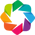

In [111]:
hv.notebook_extension('bokeh', 'matplotlib')

In [112]:
%output backend='matplotlib'

You can use the `%%opts` cell magic command to set some options (e.g. change the geographical projection).

`opts` is not a built-in magic command, it's provided by HoloViews.

See `OptsMagic` class in `holoviews.ipython.magics.py` and `OptsSpec` in `holoviews.util.parser` or call `%%opts?` in a notebook cell.

:Feature   [Longitude,Latitude]
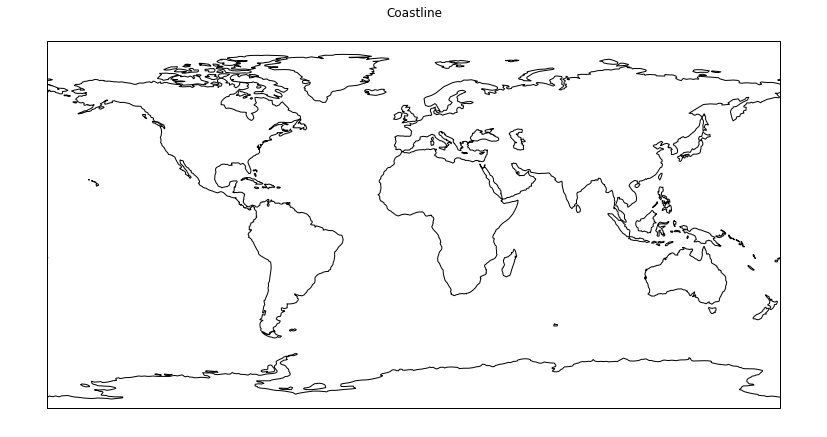

In [5]:
%%output size=400
%%opts Feature [projection=ccrs.PlateCarree()]
gf.coastline

You can create HoloViews layouts by combining and overlaying several GeoViews `Feature` elements.

:Layout
   .Overlay.I  :Overlay
      .Coastline.I :Feature   [Longitude,Latitude]
      .Borders.I   :Feature   [Longitude,Latitude]
   .Overlay.II :Overlay
      .Ocean.I  :Feature   [Longitude,Latitude]
      .Rivers.I :Feature   [Longitude,Latitude]
      .Lakes.I  :Feature   [Longitude,Latitude]
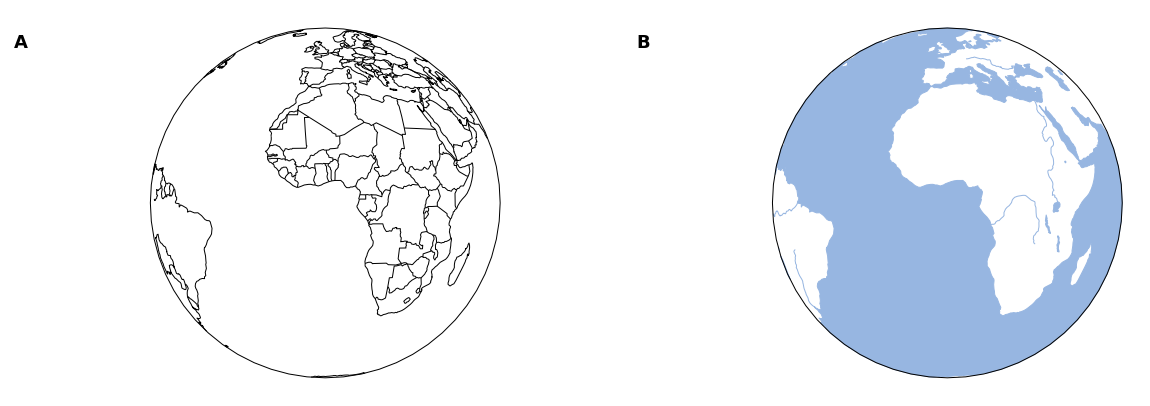

In [7]:
%%output size=200
%%opts Feature [projection=ccrs.Geostationary()]
# you can use hv.Overlay or the '*' operator to combine several GeoViews features into a single HoloViews layout
layout = hv.Overlay([gf.coastline, gf.borders]) + gf.ocean * gf.rivers * gf.lakes
layout

See [How to customize plots](http://holoviews.org/user_guide/Customizing_Plots.html) in the HoloViews documentation.

## Create a GeoViews feature from Natural Earth

In fact, `gf.ocean` is just a shortcut for `gv.Feature(cf.OCEAN, group='Ocean')`.

Documentation for the [Cartopy Feature interface](http://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html).

A GeoViews `Feature` is a Cartopy feature with additional properties and methods.

In `geoviews.feature.py` there isn't a `Feature` for [graticules](http://desktop.arcgis.com/en/arcmap/10.3/map/page-layouts/what-are-grids-and-graticules-.htm). But you can find this feature on [NaturalEarth](http://www.naturalearthdata.com/).

*NaturalEarth* $\rightarrow$ *Cartopy* $\rightarrow$ *GeoViews*

First, create a Cartopy feature.

In [8]:
cartopy_graticules = cf.NaturalEarthFeature(category='physical',
                                            name='graticules_30',
                                            scale='110m')
cartopy_graticules

`scale` is the dataset scale, i.e. one of '10m', '50m', or '110m'.

Corresponding to 1:10,000,000, 1:50,000,000, and 1:110,000,000 respectively.

Then, use the Cartopy feature to create a GeoViews feature.

:Feature   [Longitude,Latitude]
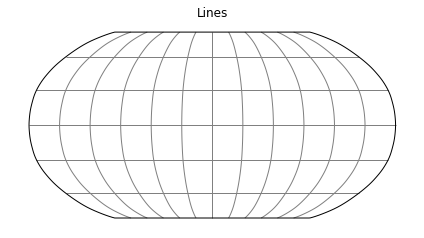

In [9]:
%%output size=200
%%opts Feature.Lines (facecolor='none' edgecolor='gray') [projection=ccrs.Robinson()]
graticules = gv.Feature(cartopy_graticules, group='Lines')
graticules

## Create a GeoViews feature from any shapefile

*Shapefile* $\rightarrow$ *Cartopy* $\rightarrow$ *GeoViews*

Shapefile: [American Indian/Alaska Native Areas/Hawaiian Home Lands](https://www.census.gov/geo/maps-data/data/cbf/cbf_aiannh.html) from United Stated Census Bureau.

**Note:** this file works, but it takes ~10s to be processed.

Cartopy `shapereader` provides an interface for accessing the contents of a shapefile.

In [19]:
shp_filepath = os.path.join(data_dir, 'tl_2017_us_aiannh', 'tl_2017_us_aiannh.shp')
reader = shpreader.Reader(shp_filepath)

In [20]:
# Note: you need to know the cartopy CRS in which the provided geometries are defined.
shapely_feature = cf.ShapelyFeature(geometries=reader.geometries(), crs=ccrs.PlateCarree())
shapely_feature

:Feature   [Longitude,Latitude]
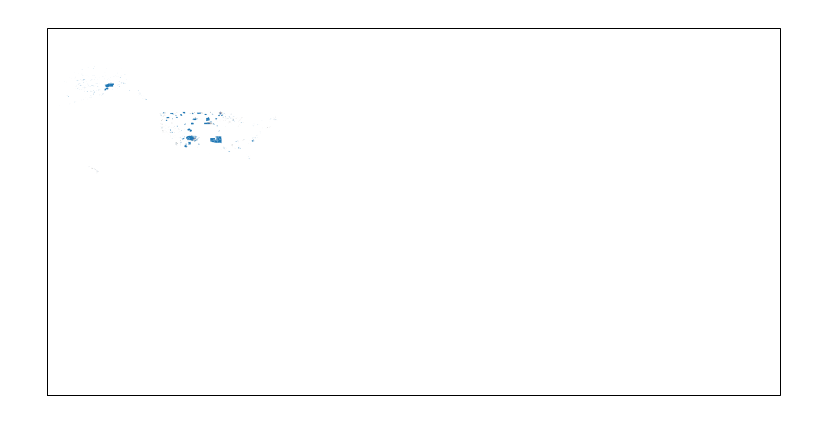

In [21]:
%%output size=400
%%opts Feature.Lines (facecolor='none' edgecolor='black') [projection=ccrs.PlateCarree()]
homelands = gv.Feature(shapely_feature)
homelands

## Combine all GeoViews features

:Overlay
   .Ocean.I     :Feature   [Longitude,Latitude]
   .Land.I      :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
   .Lines.I     :Feature   [Longitude,Latitude]
   .Feature.I   :Feature   [Longitude,Latitude]
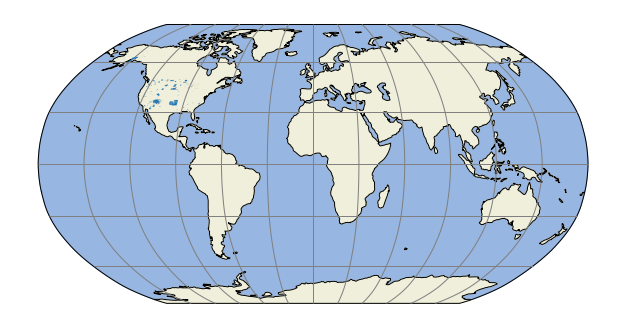

In [23]:
%%output size=300
%%opts Feature [projection=ccrs.Robinson()]
layout = hv.Overlay([gf.ocean, gf.land, gf.coastline, graticules, homelands])
layout

## TODO: replace UK example with another one

In [115]:
shp_filepath = os.path.join(data_dir, 'boundaries', 'boundaries.shp')
reader = shpreader.Reader(shp_filepath)

In [81]:
csv_filepath = os.path.join(data_dir, 'referendum.csv')
df = pd.read_csv(csv_filepath)
df.head()

leaveVoteshare  regionName    turnout                  name       code
0        4.100000   Gibraltar  83.500000             Gibraltar  BS0005003
1       69.599998  North East  65.500000            Hartlepool  E06000001
2       65.500000  North East  64.900002         Middlesbrough  E06000002
3       66.199997  North East  70.199997  Redcar and Cleveland  E06000003
4       61.700001  North East  71.000000      Stockton-on-Tees  E06000004

In [82]:
referendum = hv.Dataset(data=df)

In [83]:
ndoverlay = gv.Shape.from_records(records=reader.records(), 
                                  dataset=referendum, 
                                  on='code',
                                  value='leaveVoteshare',
                                  index=['name', 'regionName'],
                                  crs=ccrs.PlateCarree())

:NdOverlay   [Index,name,regionName]
   :Shape   [Longitude,Latitude]   (leaveVoteshare)
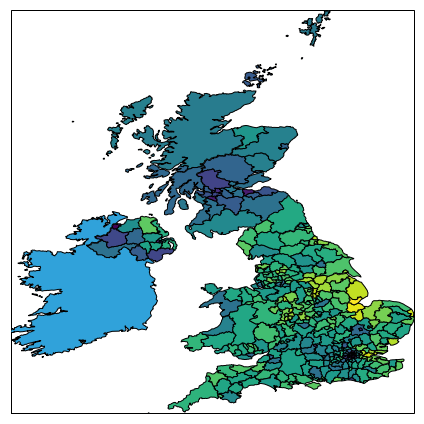

In [84]:
%%output size=200
ndoverlay

## Basel parks

In [332]:
# Basel shapefiles from https://extract.bbbike.org/
shp_filepath = os.path.join(data_dir, 'basel_shapefiles', 'natural.shp')
reader = shpreader.Reader(shp_filepath)

An alternative to using the Cartopy Feature interface is adding geometries to a `NdOverlay`.

In [333]:
parks_generator = (r for r in reader.records() if r.attributes['type'] == 'park')

Apparently there are some issues with this shapefile. Many shapely records are invalid. Luckily, it's easy to filter them out with a simple condition.

In [334]:
parks = [p for p in parks_generator if p.geometry.area > 0]
print(parks[0].attributes)

{'osm_id': 12362783, 'name': 'Kannenfeldpark', 'type': 'park'}


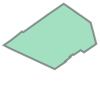

In [335]:
geometries = [p.geometry for p in parks]
geometries[0]

:NdOverlay   [Element]
   :Shape   [Longitude,Latitude]   (Level)
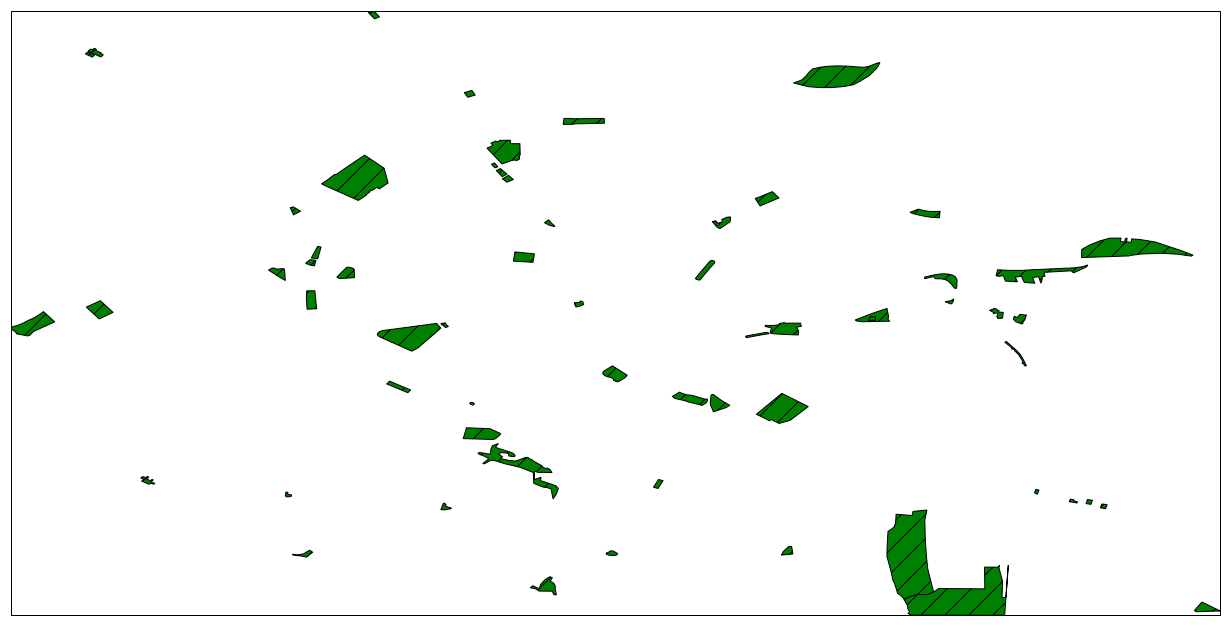

In [359]:
%%opts Shape (facecolor='green' hatch='/') NdOverlay [aspect=2]
hv.NdOverlay({i: gv.Shape(geom, crs=ccrs.PlateCarree()) for i, geom in enumerate(geometries)})

In [149]:
%%time
df = pd.read_csv('data/2014_us_cities.csv').sort_values(by='pop')

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 167 ms


In [150]:
df.tail()

name      pop        lat         lon
4  Philadelphia   1539313  39.952335  -75.163789
3       Houston   2129784  29.758938  -95.367697
2       Chicago   2705627  41.875555  -87.624421
1   Los Angeles   3826423  34.053717 -118.242727
0      New York   8287238  40.730599  -73.986581

In [151]:
# Coordinate system aware version of a HoloViews dataset
cities_ds = gv.Dataset(data=df, kdims=['lat', 'lon'])

In [152]:
cities_ds.crs

## TODO: create something with tile providers


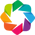

In [153]:
hv.notebook_extension('bokeh')

In [154]:
tiles = {
    'OpenMap': WMTSTileSource(url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'),
    'ESRI': WMTSTileSource(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'),
    'Wikipedia': WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png'),
    'STAMEN_TONER': STAMEN_TONER,
    'STAMEN_TERRAIN': STAMEN_TERRAIN}

In [155]:
%%output size=200
tile_geo = gv.WMTS(tiles['STAMEN_TERRAIN'], crs=crs.GOOGLE_MERCATOR)
# click on the "Wheel Zoom" tool and zoom out
tile_geo

:WMTS   [Longitude,Latitude]

In [159]:
%%output size=200
# %%opts Points [tools=['hover'] size_index=2 color_index=2 xaxis=None yaxis=None]
# %%opts Points [width=600 height=550 tools=['hover'] color_index='pop'] ('color': 'red')
cities_points = cities_ds.to(gv.Points, groupby='pop', dynamic=True)
dynamic_map = gv.WMTS(tiles['ESRI']) * cities_points
dynamic_map

:DynamicMap   [pop]

### TODO: gridded datasets


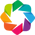

In [95]:
hv.notebook_extension('bokeh')

In [96]:
%%opts Image [colorbar=True fig_size=400 xaxis=None yaxis=None] (cmap='viridis')
ds_air = xr.open_dataset('./data/air.mon.mean.nc')

In [97]:
dataset = gv.Dataset(ds_air, label=ds_air.attrs['title'])
dataset.data

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, time: 840)
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 1948-03-01 ...
Data variables:
    air      (time, lat, lon) float64 ...
Attributes:
    description:    Data from NCEP initialized reanalysis (4x/day).  These ar...
    platform:       Model
    Conventions:    COARDS
    NCO:            20121012
    history:        Thu May  4 20:11:16 2000: ncrcat -d time,0,623 /Datasets/...
    title:          monthly mean air.sig995 from the NCEP Reanalysis
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reana...
    dataset_title:  NCEP-NCAR Reanalysis 1

In [98]:
img_air = dataset.to(gv.Image, ['lon', 'lat'], dynamic=True)

In [99]:
img_air * gf.borders() * gf.coastline()

:DynamicMap   [time]

In [100]:
%%opts WMTS [width=450 height=250 xaxis=None yaxis=None]
hv.NdLayout({name: gv.WMTS(wmts, extents=(0, -90, 360, 90), crs=crs.PlateCarree())
            for name, wmts in tiles.items()}, kdims=['Source']).cols(2)

:NdLayout   [Source]
   :WMTS   [Longitude,Latitude]